In [2]:

import os
import sys
import re
import numpy as np 
import pandas as pd
from pathlib import Path
import skimage.io as io
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('white')

import torch
from torchvision.utils import make_grid
# from umap import UMAP



print('pandas : ', pd.__version__)
print('numpy : ', np.__version__)
print('pytorch : ', torch.__version__)
print('python : ', sys.version)
# !python -V


pandas :  1.3.5
numpy :  1.21.5
pytorch :  1.8.0
python :  3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 05:37:49) [MSC v.1916 64 bit (AMD64)]


- notebook
    - pandas :  1.3.5
    - numpy :  1.21.5
    - pytorch :  1.8.0
    - python :  3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 05:37:49) [MSC v.1916 64 bit (AMD64)]

##### 討論筆記


- 2022.117 
    - 把每個物種海拔分布中點或平均值算出來 然後照海拔分群(文章裡應該有說每多少公尺分一段，然後在每一群內直接計算 feature space 的大小
    - 因為 VSC 在訓練時就把所有值都加上約束了，就算把每個值都獨立看 也會看到幾乎一樣的結果
    - 要描述的東西是以物種為單位 點跟點之間的關係，不是看每個維度的分散程度
    - 多樣性低 會有差的是物種點佔據的 feature space 會明顯變小，所以你要嘛描述每個點到原點的距離分布 或是描述任意兩點間的距離的分布。
    - 至於分布如何描述 就至少有平均值 標準差 四分位差 boxblot whiskers max, min 這些東西可以用
        - 印象中我之前是計算pairwised distance 的 whiskers max - min
    - 目標方法可以是很抽象的 
        - 譬如說目標是海拔段的物種外觀多樣性 那下一個最近的問題就是海拔怎麼切 多樣性要用什麼指標 然後就會回到手邊有怎樣的資料 可以達成哪些指標計算 最後才是回到程式上

### 研究假說
#### Benign environments promote thermal trait diversity

- Functional diversity沿緯度與海拔梯度的變化沒有定論

- Favorability hypothesis
    - 高緯度 高海拔
        - Climatic variability hypothesis： 耐冷又耐熱
        - Favorability hypothesis: 適應冷 就不能適應熱 Trade-offs hypothesis

    - 低緯度 低海拔
        - Climatic variability hypothesis： specialization (environmental filtering)
        - Favorability hypothesis: 種間變異大 （同一個assemblage內、種間競爭影響大）

- 預測
    - Thermal tolerance -functional trait
    - Range size


#### 從群聚層級檢視功能性多樣性
- 功能性多樣性(Functional diversit)沿緯度與海拔梯度的變化
    - Functional trait
        - TT(Thermal tolerance)
        - RS(Range size)
    - Morphology
        - 這裡的形態特徵是經過Autoencoder提取出來的抽象特徵，而非傳統人為主觀定義的
            - 抽象特徵(a.k.a. z /Latent space / Feature)
            - 以物種為單位呈現特徵空間(Feature Space)
                - 取物種均值/中位數(Dimension = (1,512))  

- 研究問題
    - 敘述性統計挖掘潛在關聯
        - 檢視形態特徵沿緯度與海拔梯度的變化
            - (按不同緯度)在不同海達下Feature Space的變異程度
        - 檢視不同功能特徵間彼此的關聯
            - 目前已分析RR與TS
            - 形態特徵與RS及TT的關聯
    
    - 預測
        - 找出具有預測1.海拔分布、2.耐溫能力的關鍵形態特徵


### 讀取資料、計算物種為單位的Feature Space

##### 讀取coding(latent space)

In [3]:
coding = pd.read_csv('latent_space/vsc_epoch_31914/codes.csv', sep='\t', index_col=0 )
filename = coding.filename.apply(lambda str_ : Path(str_).stem.split('_cropped')[0])
coding = coding.iloc[:,:-1]
coding

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.001079,-0.000544,0.000399,-0.003642,0.000518,0.000561,-0.001321,-0.003015,0.003724,0.002218,...,0.000905,0.004727,0.003005,-0.002860,0.002981,-0.000168,-0.317842,-0.004001,0.005765,-0.003228
1,0.002735,0.002735,0.003984,-0.005105,0.000391,0.006046,-0.001291,0.004539,0.008044,-0.000786,...,-0.005432,0.004877,0.000755,-0.005382,-0.002671,0.002536,0.386901,-0.002686,0.005009,-0.002152
2,-0.003183,-0.000131,-0.004032,0.001230,-0.003498,0.000523,-0.000668,-0.000690,0.004566,0.002496,...,0.002488,-0.000839,-0.005443,0.000650,0.001565,0.002283,0.917296,0.000898,-0.002063,-0.002445
3,0.000472,0.005015,0.000905,0.001533,0.000057,-0.004833,0.000618,0.000556,0.002746,-0.000695,...,-0.004337,-0.000667,0.003901,-0.000396,0.004565,0.004297,-0.266727,0.005127,-0.002627,0.000675
4,0.000497,-0.000845,-0.000639,0.001082,-0.002412,-0.001428,-0.000601,0.002882,0.004398,-0.000045,...,-0.003754,0.001454,0.002621,0.002970,0.003609,-0.001059,1.142986,0.001799,0.000259,0.002043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8870,0.001646,0.000607,0.001782,-0.001175,-0.000101,0.003103,0.000210,0.001348,-0.000828,0.003163,...,-0.002231,0.003434,-0.000442,-0.000222,0.003272,-0.000474,0.103783,0.001336,0.001721,-0.000449
8871,0.004085,0.001911,0.002930,-0.003200,0.001421,0.002434,-0.002131,0.003071,0.001643,-0.001244,...,-0.002081,0.003610,0.000924,-0.005030,0.002146,-0.000238,1.017337,0.001400,0.000349,0.001595
8872,0.001755,0.002030,0.000953,-0.003534,0.003475,0.003228,-0.001283,0.004413,0.007220,-0.001518,...,-0.002994,0.001752,0.000181,-0.000882,-0.001621,-0.002594,0.326988,0.000365,0.002700,-0.001363
8873,-0.000686,0.001456,0.008264,-0.002041,0.002064,0.001090,-0.003158,0.003685,0.002593,0.001769,...,-0.002412,0.008262,0.005356,0.000561,0.001693,-0.002856,-0.566896,-0.000610,0.002368,-0.002427


- 讀取並刪除破損及問題檔案 

In [4]:
dir_problemed = Path('../data/Problemed_data')
print(list(dir_problemed.iterdir()))
broken_over40 = list(dir_problemed.joinpath('Broken_over40').glob('*.png'))
print(len(broken_over40))
broken_over40 = set([path.stem.split('_cropped')[0] for path in broken_over40])
print(len(broken_over40))

broken_20_40 = list(dir_problemed.joinpath('Broken_20-40').glob('*.png'))
print(len(broken_20_40))
broken_20_40  = set([path.stem.split('_cropped')[0] for path in broken_20_40 ])
print(len(broken_20_40))

broken = broken_over40 | broken_20_40
print(len(broken))

df_broken =  pd.DataFrame(list(broken), index=range(len(broken)), columns=['broken'])

fname_broken = pd.merge(filename, df_broken,
        left_on='filename', right_on='broken', how ='left')
index_notbroken = fname_broken.query('broken.isnull().values').index.values
coding = coding.iloc[index_notbroken]
print(coding.shape)

[WindowsPath('../data/Problemed_data/Broken_10-20'), WindowsPath('../data/Problemed_data/Broken_20-40'), WindowsPath('../data/Problemed_data/Broken_over40'), WindowsPath('../data/Problemed_data/Cut'), WindowsPath('../data/Problemed_data/NGwimgs'), WindowsPath('../data/Problemed_data/problemed.csv'), WindowsPath('../data/Problemed_data/TERSI'), WindowsPath('../data/Problemed_data/篩選原則與流程.docx')]
82
81
241
241
316
(8562, 512)


##### 讀取coding的metadate 
- 探索thermal與rangesize 資料
- ~~建立檔名與物種名及thermal、rangesize的關聯檔~~
    - 見data/meta_thermal_rangesize/get_meta.ipynb
    - 整理好的關聯檔為"df_ori_TTRS_all.csv'"

- 讀取檔名與TTRS的關聯檔

In [5]:
col_TTRS_sample_based = ['fname', 'No', 'Location', 'Family', 'Species', 'Altitude', 'W_length',
       'B_length', 'Dw(g)', 'CTmax', 'CTmin', 'Tmax', 'Tmin', 'Tmean', 'DTR'] 

col_TTRS_sp_based = ['fname', 'No', 'Location', 'Family', 'Species', 'Sample Size', 'TTRS_Elev_up', 'TTRS_Elev_low', 'TTRS_Elev_mid',
       'TTRS_RS', 'TTRS_W_length', 'TTRS_B_length', 'TTRS_Weight',
       'TTRS_CTmax', 'TTRS_CTmin', 'TTRS_CTrange', 'TTRS_Tmax', 'TTRS_Tmin',
       'TTRS_Tmean', 'TTRS_DTR']

In [6]:
df_imgs_TTRS = pd.read_csv('../data/meta_thermal_rangesize/meta/df_ori_TTRS_all.csv', index_col=0)
# df_imgs_TTRS.dropna(how='all')
# 去掉台灣資料(均為空值)，僅包含馬來西亞與中國資料
# df_imgs_TTRS = df_imgs_TTRS.query('No.notnull()')
df_imgs_TTRS

,fname,No,Location,Family,Species,Altitude,W_length,B_length,Dw(g),CTmax,...,TTRS_W_length,TTRS_B_length,TTRS_Weight,TTRS_CTmax,TTRS_CTmin,TTRS_CTrange,TTRS_Tmax,TTRS_Tmin,TTRS_Tmean,TTRS_DTR
0,Aberrasine lichenshihi_male_FBG_10-IV-2015_SWu...,NaN,Taiwan,Erebidae,Aberrasine lichenshihi,NaN,NaN,NaN,NaN,NaN,...,9.122,7.582308,0.00340,NaN,NaN,NaN,29.739528,20.135378,23.956410,9.604150
1,Abraxas adilluminata_female_Biluxi_1-VII-2015_...,NaN,Taiwan,Geometridae,Abraxas adilluminata,NaN,NaN,NaN,NaN,NaN,...,24.270,16.025000,0.02530,NaN,-2.5,NaN,23.629525,16.484351,19.288741,7.145173
2,Abraxas adilluminata_female_Hewang_28-X-2015_d...,NaN,Taiwan,Geometridae,Abraxas adilluminata,NaN,NaN,NaN,NaN,NaN,...,24.270,16.025000,0.02530,NaN,-2.5,NaN,23.629525,16.484351,19.288741,7.145173
3,Abraxas adilluminata_female_MTTS1558_1,NaN,Taiwan,Geometridae,Abraxas adilluminata,NaN,NaN,NaN,NaN,NaN,...,24.270,16.025000,0.02530,NaN,-2.5,NaN,23.629525,16.484351,19.288741,7.145173
4,Abraxas adilluminata_female_MTTS302_1,NaN,Taiwan,Geometridae,Abraxas adilluminata,NaN,NaN,NaN,NaN,NaN,...,24.270,16.025000,0.02530,NaN,-2.5,NaN,23.629525,16.484351,19.288741,7.145173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8917,URA02_SJTT0713_1_female,SJTT0713,China,Uraniidae,SJ_URA02,860.0,9.80,7.14,0.0040,NaN,...,12.326,9.526000,0.00946,45.1,-2.3,47.4,27.522405,17.946845,21.213281,9.575560
8918,URA02_SJTT0747_1 _male,SJTT0747,China,Uraniidae,SJ_URA02,860.0,10.71,7.67,0.0035,NaN,...,12.326,9.526000,0.00946,45.1,-2.3,47.4,27.522405,17.946845,21.213281,9.575560
8919,URA02_SJTT0747_1_male,SJTT0747,China,Uraniidae,SJ_URA02,860.0,10.71,7.67,0.0035,NaN,...,12.326,9.526000,0.00946,45.1,-2.3,47.4,27.522405,17.946845,21.213281,9.575560
8920,URA02_SJTT0812_1_male,SJTT0812,China,Uraniidae,SJ_URA02,860.0,10.39,7.44,0.0031,NaN,...,12.326,9.526000,0.00946,45.1,-2.3,47.4,27.522405,17.946845,21.213281,9.575560


- 檢視各地區有多少物種
    - Location
        - China        672
        - Malaysia    1520
        - Taiwan       320

In [7]:
print(
    (df_imgs_TTRS.groupby(['Location'])
 .Species
 .nunique()
))

Loc_sp = (df_imgs_TTRS.groupby(['Location'])
 .Species
 .unique()
)
Loc_sp

Location
China        672
Malaysia    1520
Taiwan       320
Name: Species, dtype: int64


Location
China       [SJ_ARC10, SJ_ARC01, SJ_ARC02, SJ_ARC09, SJ_AR...
Malaysia    [CA_RSCRA49, CA_CRA61, CA_LIT32, CA_RSPYR10, C...
Taiwan      [Aberrasine lichenshihi, Abraxas adilluminata,...
Name: Species, dtype: object

- 讀取已各樣本測量值為根據的資料
    - 台灣部分無資料


In [8]:
df_imgs_TTRS_sample_based = df_imgs_TTRS.query('No.notnull()')[col_TTRS_sample_based]
df_imgs_TTRS_sample_based

,fname,No,Location,Family,Species,Altitude,W_length,B_length,Dw(g),CTmax,CTmin,Tmax,Tmin,Tmean,DTR
577,ARC01_SJTT0564_1_male,SJTT0564,China,Erebidae,SJ_ARC10,2000.0,33.30,21.52,0.12310,NaN,1.0,16.872565,9.317783,12.286201,7.554783
578,ARC01_SJTT0586_1_male,SJTT0586,China,Erebidae,SJ_ARC01,2000.0,31.31,20.52,0.07980,NaN,0.1,20.249839,10.111318,14.087058,10.138521
579,ARC01_SJTT0925_1_male,SJTT0925,China,Erebidae,SJ_ARC01,1536.0,35.22,22.29,0.09540,NaN,5.2,26.812227,16.849169,20.694877,9.963058
580,ARC02_SJRS00701_male,SJRS00701,China,Erebidae,SJ_ARC02,2856.0,27.32,19.65,0.08198,NaN,NaN,20.249839,10.111318,14.087058,10.138521
581,ARC02_SJRS00733_male,SJRS00733,China,Erebidae,SJ_ARC02,1864.0,29.94,23.47,0.13256,NaN,NaN,24.251990,15.451680,18.841415,8.800310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8917,URA02_SJTT0713_1_female,SJTT0713,China,Uraniidae,SJ_URA02,860.0,9.80,7.14,0.00400,NaN,NaN,29.702681,19.610288,22.794524,10.092393
8918,URA02_SJTT0747_1 _male,SJTT0747,China,Uraniidae,SJ_URA02,860.0,10.71,7.67,0.00350,NaN,-1.7,29.702681,19.610288,22.794524,10.092393
8919,URA02_SJTT0747_1_male,SJTT0747,China,Uraniidae,SJ_URA02,860.0,10.71,7.67,0.00350,NaN,-1.7,29.702681,19.610288,22.794524,10.092393
8920,URA02_SJTT0812_1_male,SJTT0812,China,Uraniidae,SJ_URA02,860.0,10.39,7.44,0.00310,NaN,-2.9,29.702681,19.610288,22.794524,10.092393


- 讀取以物種均值為根據的TTRS資料|

In [9]:
df_imgs_TTRS_sp_based = df_imgs_TTRS[col_TTRS_sp_based]
df_imgs_TTRS_sp_based 

,fname,No,Location,Family,Species,Sample Size,TTRS_Elev_up,TTRS_Elev_low,TTRS_Elev_mid,TTRS_RS,TTRS_W_length,TTRS_B_length,TTRS_Weight,TTRS_CTmax,TTRS_CTmin,TTRS_CTrange,TTRS_Tmax,TTRS_Tmin,TTRS_Tmean,TTRS_DTR
0,Aberrasine lichenshihi_male_FBG_10-IV-2015_SWu...,NaN,Taiwan,Erebidae,Aberrasine lichenshihi,17.0,1110.0,343.0,726.5,767.0,9.122,7.582308,0.00340,NaN,NaN,NaN,29.739528,20.135378,23.956410,9.604150
1,Abraxas adilluminata_female_Biluxi_1-VII-2015_...,NaN,Taiwan,Geometridae,Abraxas adilluminata,2.0,1644.0,1511.0,1577.5,133.0,24.270,16.025000,0.02530,NaN,-2.5,NaN,23.629525,16.484351,19.288741,7.145173
2,Abraxas adilluminata_female_Hewang_28-X-2015_d...,NaN,Taiwan,Geometridae,Abraxas adilluminata,2.0,1644.0,1511.0,1577.5,133.0,24.270,16.025000,0.02530,NaN,-2.5,NaN,23.629525,16.484351,19.288741,7.145173
3,Abraxas adilluminata_female_MTTS1558_1,NaN,Taiwan,Geometridae,Abraxas adilluminata,2.0,1644.0,1511.0,1577.5,133.0,24.270,16.025000,0.02530,NaN,-2.5,NaN,23.629525,16.484351,19.288741,7.145173
4,Abraxas adilluminata_female_MTTS302_1,NaN,Taiwan,Geometridae,Abraxas adilluminata,2.0,1644.0,1511.0,1577.5,133.0,24.270,16.025000,0.02530,NaN,-2.5,NaN,23.629525,16.484351,19.288741,7.145173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8917,URA02_SJTT0713_1_female,SJTT0713,China,Uraniidae,SJ_URA02,5.0,2000.0,860.0,1430.0,1140.0,12.326,9.526000,0.00946,45.1,-2.3,47.4,27.522405,17.946845,21.213281,9.575560
8918,URA02_SJTT0747_1 _male,SJTT0747,China,Uraniidae,SJ_URA02,5.0,2000.0,860.0,1430.0,1140.0,12.326,9.526000,0.00946,45.1,-2.3,47.4,27.522405,17.946845,21.213281,9.575560
8919,URA02_SJTT0747_1_male,SJTT0747,China,Uraniidae,SJ_URA02,5.0,2000.0,860.0,1430.0,1140.0,12.326,9.526000,0.00946,45.1,-2.3,47.4,27.522405,17.946845,21.213281,9.575560
8920,URA02_SJTT0812_1_male,SJTT0812,China,Uraniidae,SJ_URA02,5.0,2000.0,860.0,1430.0,1140.0,12.326,9.526000,0.00946,45.1,-2.3,47.4,27.522405,17.946845,21.213281,9.575560


In [10]:

df_coding_sp_based = pd.DataFrame(filename).merge(df_imgs_TTRS_sp_based ,
               left_on='filename',
               right_on='fname',
               how='left'
               ).loc[:,"fname":]

assert df_coding_sp_based.query('fname.isnull()').size == 0
df_coding_sp_based = df_coding_sp_based.iloc[index_notbroken]  # 選取翅型較完好的資料
df_coding_sp_based

## 檔名完全吻合，沒有空值

,fname,No,Location,Family,Species,Sample Size,TTRS_Elev_up,TTRS_Elev_low,TTRS_Elev_mid,TTRS_RS,TTRS_W_length,TTRS_B_length,TTRS_Weight,TTRS_CTmax,TTRS_CTmin,TTRS_CTrange,TTRS_Tmax,TTRS_Tmin,TTRS_Tmean,TTRS_DTR
0,Not_id_yet_CARS1607,CARS1607,Malaysia,Geometridae,CA_RSGEO173,2.0,1066.0,796.0,931.0,270.0,7.810000,5.895000,0.002515,NaN,NaN,NaN,24.182177,19.147115,21.252225,5.035062
1,CATT1380_1,CATT1380,Malaysia,Erebidae,CA_LIT41,12.0,1374.0,509.0,941.5,865.0,16.979167,16.267500,0.033555,41.500000,4.900000,36.600000,23.142452,17.743606,20.059967,5.398846
2,NOC040_SJTT0415_1_male,SJTT0415,China,Noctuidae,SJ_NOC040,19.0,3579.0,2000.0,2789.5,1579.0,17.213158,15.001053,0.040791,39.087500,0.462500,38.625000,18.226008,10.069118,13.274664,8.156890
3,CARS1467,CARS1467,Malaysia,Pyralidae,CA_PYR29,28.0,1374.0,1372.0,1373.0,2.0,9.036429,10.045600,0.004444,NaN,1.400000,NaN,21.871878,15.995126,18.598129,5.876752
4,CARS2225,CARS2225,Malaysia,Crambidae,CA_RSCRA231,2.0,470.0,470.0,470.0,0.0,9.545000,10.370000,0.005880,NaN,NaN,NaN,26.085936,20.279590,22.749810,5.806346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8870,CRA11_SJTT2092_1_female,SJTT2092,China,Crambidae,SJ_CRA11,7.0,2612.0,2602.0,2607.0,10.0,11.752857,10.390000,0.008116,43.600000,3.433333,40.166667,21.561719,11.637813,15.693849,9.923906
8871,GEO131_SJTT2202_1_male,SJTT2202,China,Geometridae,SJ_GEO131,14.0,3579.0,2000.0,2789.5,1579.0,19.925714,12.546429,0.014088,39.485714,-1.566667,41.052381,21.294774,11.288172,15.213427,10.006602
8872,CATT1548_1,CATT1548,Malaysia,Erebidae,CA_LIT33,25.0,1959.0,470.0,1214.5,1489.0,8.589583,5.871667,0.002338,36.487500,-1.500000,37.987500,20.795676,16.016036,18.098152,4.779640
8873,Callopistria maillardi maillardi_male-2_800px,NaN,Taiwan,Noctuidae,Callopistria maillardi maillardi,7.0,1644.0,900.0,1272.0,744.0,16.167143,14.258571,0.023943,45.050000,-0.050000,45.100000,28.552698,19.029937,22.687887,9.522760


In [11]:
df_coding_sp_based.query('Location=="Taiwan"').describe()

,Sample Size,TTRS_Elev_up,TTRS_Elev_low,TTRS_Elev_mid,TTRS_RS,TTRS_W_length,TTRS_B_length,TTRS_Weight,TTRS_CTmax,TTRS_CTmin,TTRS_CTrange,TTRS_Tmax,TTRS_Tmin,TTRS_Tmean,TTRS_DTR
count,545.000000,545.000000,545.000000,545.000000,545.000000,540.000000,545.000000,540.000000,327.000000,400.000000,260.000000,545.000000,545.000000,545.000000,545.000000
mean,20.607339,2209.667890,1431.442202,1820.555046,778.225688,21.156144,16.744560,0.063679,41.097547,1.620646,39.140709,22.405549,15.162724,18.023310,7.242825
std,37.455905,596.887979,695.745731,560.562280,650.964272,6.477187,4.928877,0.075037,2.436606,2.736179,2.996173,4.110278,3.094474,3.408026,1.189567
min,1.000000,900.000000,343.000000,722.000000,0.000000,8.695455,6.383871,0.002363,32.700000,-4.000000,24.700000,14.220765,8.023275,10.750687,5.513848
25%,3.000000,1734.000000,900.000000,1447.500000,210.000000,16.716304,13.092857,0.018440,39.658824,-0.200000,37.750000,19.902970,13.434708,15.947922,6.356534
50%,8.000000,2039.000000,1511.000000,1775.000000,732.000000,20.175550,16.025000,0.042725,41.000000,1.375000,39.381667,22.212620,15.435441,18.153612,6.773857
75%,21.000000,2960.000000,1995.000000,2184.500000,1190.000000,24.258000,19.370000,0.071793,42.580952,3.222500,40.770455,25.251359,17.235435,20.330487,8.046644
max,422.000000,3140.000000,2993.000000,3050.000000,2650.000000,51.950000,31.940000,0.595367,48.000000,14.600000,45.150000,31.079402,21.921056,25.469858,9.937991


### 分析


#### latent space初步探索


- load model

In [13]:
from utils.networks import VSC
from utils.utils import load_model

# 指定GPU位置
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# torch.cuda.empty_cache()  # 清除GPU記憶體暫存

channels= [32, 64, 128, 256, 512, 512]
model = VSC(cdim=3, hdim=512, channels=channels, image_size=256)

ck = 31914
ck_path = f'pretrained/vsc_epoch_{ck:d}.pth'
load_model(model, ck_path, map_location=device)

model = model.to(device)


#### 內插檢視512維表徵的變化
- 使用Autoencoder模型學習到的表徵(representation)/coding，重現鱗翅目型態的主要成分
- ~~所有維度(512維)~~ => 重要維度(std > std_mean)


- 檢視z(latent vector 分布狀態)
    - 檢視z的分佈狀態
    - 可觀察到蛾類標本的表徵僅集中在少量維度(23/512維)

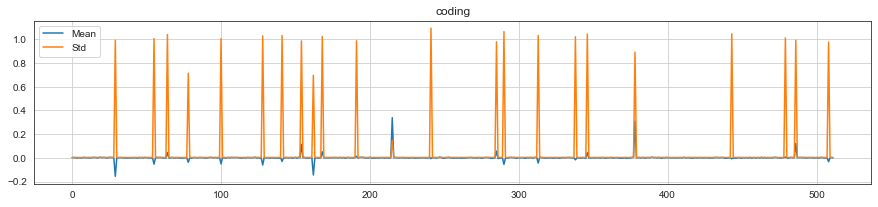

In [ ]:
coding_mean = coding.mean()
coding_std = coding.std()
settings = dict(title='coding', figsize=(15,3), grid=True)
df = pd.DataFrame({'Mean':coding_mean,'Std':coding_std} )
df.plot(**settings);


             Mean         Std
count  512.000000  512.000000
mean     0.000881    0.045462
std      0.024738    0.200347
min     -0.156705    0.002014
25%     -0.001435    0.002905
50%      0.000064    0.003004
75%      0.001505    0.003116
max      0.338374    1.094318


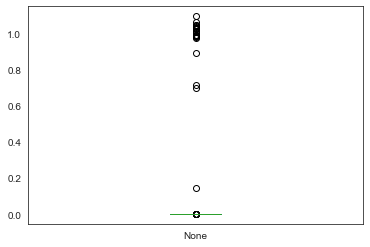

In [ ]:
# coding_std.plot.hist(bins=50 );
print(df.describe())
coding_std.plot.box();

In [ ]:
# Define sig dimensions :  std of coding > mean of std
sig_dim = df.query(f'Std > Std.mean()').index.values

print(f'Number of signuficant dimensions : {len(sig_dim)}')
print(f'Signuficant dimensions : {sig_dim}')


Number of signuficant dimensions : 23
Signuficant dimensions : ['29' '55' '64' '78' '100' '128' '141' '154' '162' '168' '191' '215' '241'
 '285' '290' '313' '338' '346' '378' '443' '479' '486' '508']


- 產出特徵的內差值
    - 針對顯著變化的維度計算其內差值
        - 0 +- 2*std 
        - z_base =  torch.zeros((1,512)。 
            - ~~基質採用各維度的均值(接近0)~~


In [ ]:
dir_save = Path(f"./results/latent")
dir_save.mkdir(parents=True, exist_ok=True)

def im_convert(tensor, f_name=None, figsize:tuple=(16, 4), dir_save=dir_save, save=False):  
    image = tensor.cpu().clone().detach().numpy() # This process will happen in normal cpu.
    image = image.transpose(1, 2, 0)              # (c,w,h) > (w,h,c)
#     image = image*std + mean                      # unnormalize
    image = image.clip(0, 1)
    plt.figure(figsize=figsize)
    plt.title(f'{f_name}')
    plt.axis('off')
    plt.imshow(image)
    
    if save:
        plt.savefig(dir_save.joinpath(f_name + '.jpg'),
                    bbox_inches='tight',
                   )
        print(f'{f_name} Saved', end='\r')
    plt.close()
    # fig_path =  f"./results/Feature_inverse"


In [ ]:
num = 30
c = 3

for dim in sig_dim:
    print(dim, end='\r')
    # 產出該維度特徵內插值
    # z_base = torch.Tensor(df.Mean).reshape(1,512)
    z_base = torch.zeros((1,512)).to(device)
    mean, std, *_ = df.loc[dim]
    interplot_ = np.linspace(mean - c*std,  mean + c*std, num)
    z_interplot = []
    for l in interplot_:
        z_base[0][int(dim)] = l
        z_interplot.append(z_base.clone())
        
    # 將該維度內插值送入decoder產生圖像
    imgs_rec = []
    with torch.no_grad():
        for idx, z in enumerate(z_interplot):
            print(idx, end='\r')
            img_rec = model.decoder(z) 
            imgs_rec.extend(img_rec)
    im_convert(make_grid(imgs_rec, nrow=10, padding=2, pad_value=255),
               f_name=f'Dimensions_{dim}', save=True)
    
# imgs_rec_all = torch.stack(imgs_rec)
# im_convert(make_grid(imgs_rec_all, nrow=num, padding=2, pad_value=255), 
#            f_name='Dimensions_All_Sig', figsize:tuple=(16, 12), save=True)


- 潛在空間(z)各維度內差圖
    - ~~row(每行): 各維度~~
    - cols(每列): 各維度內插值(由左上至右下: - 0 +)  


    ![Dimensions_479](imgs_jupyter/Dimensions_479.jpg)
    ![Dimensions_168](imgs_jupyter/Dimensions_168.jpg)

    
<!-- ![潛在空間(z)各維度內差圖](imgs_jupyter/latent_interplot.JPG) -->




#### 檢視z的std 變異程度

In [ ]:
# 分別索引、建立三地區的coding值
# 僅檢視有顯著變化的維度
locations =  ["Malaysia", "Taiwan", "China"]

df_Location = df_coding_sp_based[['Location']].reset_index(drop=True)

idxs = [df_Location.query(f'Location=="{loc}"').index.values 
                             for loc in locations]

coding_list= [coding.reset_index(drop=True).loc[idx, sig_dim] for idx in idxs]


sample_size = [len(idx)for idx in idxs]
loc_size_ = list(dict(zip(locations, sample_size)).items())
loc_size = [f'{loc}_n={size}'  for loc, size in loc_size_]
loc_size

['Malaysia_n=4003', 'Taiwan_n=545', 'China_n=3995']

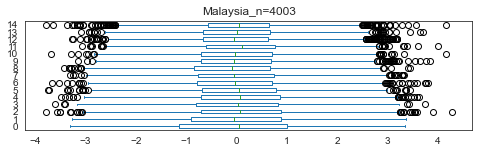

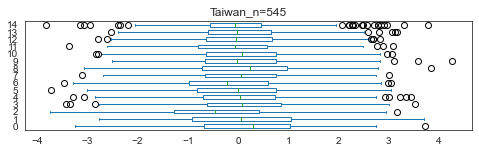

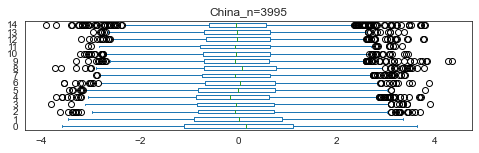

In [ ]:
figsize = (8,2)

for coding_, title in zip(coding_list,loc_size):
    coding_.plot.box(title=title,figsize=figsize, vert=False);


In [ ]:
# figsize = (6,3)
# columns_loc = dict(zip(range(3), loc_size))

# (pd.concat([coding_list[0].unstack(),
#             coding_list[1].unstack(),
#             coding_list[2].unstack(),],
#           axis=1,
#           names=locations
#           )
#  .rename(columns=columns_loc)
#  .plot.box(title='Range of Std in latent space' ,figsize=figsize)
# );


# print(f'sample size : {dict(zip(locations, sample_size))}') 


- 分地區檢視 lataent space的std 變異程度，沒有太大差異
    - 將所有維度打散成一維  

    ![Range of Std in latent space](imgs_jupyter/Range_of_Std_in_latent_space_unstack.png)  

- 討論
    - 將所有維度打散成一維，可能僅反應變異度最大的維度範圍
    - 以區域作分組可能太粗略，也許是看某類群在不同海拔?
    - 有沒有計算分散程度的指標?
    - 先用降維法進行處理，再檢視頭幾項重要維度

#### 降維分群探索
- 類群、海拔、地點?  很可能是反映類群

- 檢視維度空間多樣性
    - 地區
    - 海拔
    - 地區x海拔

- 以PCA降為視覺化可理解的三維檢視

In [ ]:
from sklearn.decomposition import PCA
from sklearn import metrics
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
pca = PCA(0.95)
embedding = pca.fit_transform(coding)

np.save('latent_space/embedding_PCA95.npy', embedding)
embedding = np.load('latent_space/embedding_PCA95.npy')

(8562, 18)


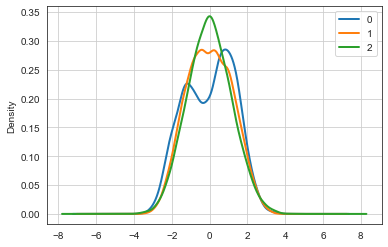

In [ ]:

df_embedding = pd.DataFrame(embedding)
print(embedding.shape)
# print(df_embedding.describe())
df_embedding.loc[:,:2].plot(kind="density", lw=2, grid=True);

In [ ]:
# (pd.DataFrame(
#     pca.explained_variance_ratio_.cumsum()
# )
#  .plot(title='Explained_variance_ratio', figsize=(6,3), grid=True )
# );
print('Number of dims for 95% explained_ratio : ', pca.explained_variance_ratio_.__len__())
pca.explained_variance_ratio_.cumsum()

Number of dims for 95% explained_ratio :  19


array([0.0812649 , 0.14791344, 0.21090369, 0.27186777, 0.33064062,
       0.38791134, 0.44264303, 0.49659032, 0.54937959, 0.59793608,
       0.64633911, 0.69424008, 0.73931049, 0.78286972, 0.82538228,
       0.86357145, 0.89838466, 0.92600386, 0.95198543])

In [ ]:
embedding_list= [df_embedding.loc[idx, :3] for idx in idxs]  #　['Malaysia', 'Taiwan', 'China]

In [ ]:
figsize = (8,1)
for embedding_, title in zip(embedding_list,loc_size):
    embedding_.loc[:,:2].plot.box(title=title,figsize=figsize, vert=False);

- 檢視PCA後embedding前三軸的數值變化範圍  
    - 台灣的範圍略小，可能只是樣本數較少?  
    
    ![Malaysia](imgs_jupyter/Range_of_Std_in_latent_space_Malaysia.png)  

    ![Taiwan](imgs_jupyter/Range_of_Std_in_latent_space_Taiwan.png)  

    ![China](imgs_jupyter/Range_of_Std_in_latent_space_China.png)

- 檢視PCA降維後各軸的變化

In [ ]:

linspace = 11
q = .01
upper = np.quantile(embedding, axis=0, q=(1-q) )
lower = np.quantile(embedding, axis=0, q=q)
# base = np.zeros((linspace, 3))
mean = np.mean(embedding, axis=0)
base = np.ones((linspace, 3)) * mean               # 各軸背景值採用該軸平均

for d in [0, 1, 2]:
    reducer_ = base.copy()  
    reducer_[:,d] = np.linspace(lower[d], upper[d], linspace)
    
    if d==0: 
        embedding_linespace = reducer_.reshape(1, linspace, -1)
    else:
        embedding_linespace = np.vstack((embedding_linespace, reducer_.reshape(1, linspace, -1)))
print("interpolation of embedding features: ", embedding_linespace.shape)

interpolation of embedding features:  (3, 11, 3)


In [ ]:
for d in [0, 1, 2]:
    embedding_inv = pca.inverse_transform(embedding_linespace[d])
    if d==0: 
        features_linespace = embedding_inv.reshape(1, linspace, -1)
    else:
        features_linespace = np.vstack(
            (features_linespace, embedding_inv.reshape(1, linspace, -1))
        )
        
print("Inverse of interpolated embedding features: ", features_linespace.shape)

Inverse of interpolated embedding features:  (3, 11, 512)


In [ ]:
features_linespace = torch.tensor(features_linespace, dtype=torch.float32).clone().detach()
with torch.no_grad():
    for d in [0, 1, 2]:
        if d==0:
            rec =  model.decoder(features_linespace[d]).reshape(1, linspace, 3, 256, 256) 
        else:
            rec = torch.cat(
                ( rec, 
                 model.decoder(features_linespace[d]).reshape(1, linspace, 3, 256, 256) )
            )
print(rec.shape)

torch.Size([3, 11, 3, 256, 256])


In [ ]:
# fig_path =  f"./results/Feature_inverse"
def im_convert_PCA(tensor, f_name=None, subtitle=None, save=False, fig_root:Path =None, figsize=(12,3)):  
    image = tensor.cpu().clone().detach().numpy() # This process will happen in normal cpu.
    image = image.transpose(1, 2, 0).clip(0,1)              # (c,w,h) > (w,h,c)
    plt.figure(figsize=figsize)
    plt.title(f'{f_name}', fontsize=24)
    plt.imshow(image)
    
    if save:
        fig_path =  fig_root.joinpath(f_name + ".jpg")
        plt.savefig(fig_path, bbox_inches='tight')
        print(f'{fig_path} Saved')
    plt.close()

dir_PCA =  Path(f"results/PCA")
dir_PCA.mkdir(exist_ok=True, parents=True)
im_convert(make_grid(rec.view(-1, 3, 256, 256), nrow=linspace, pad_value=255), 
           f_name=f"PCA_Inversed_Features_3Axis",  
           save=True , dir_save=dir_PCA, figsize=(18, 4))


- PCA前三軸視覺化
    - 前三軸解釋力占21%  
       
    ![](imgs_jupyter/PCA_Inversed_Features_3Axis.jpg)

##### UMAP 降維視覺化

In [ ]:
from umap import UMAP
from mpl_toolkits.mplot3d import Axes3D

# sns.set(style='white', context='notebook', rc={'figure.figsize':(16,12)})

In [ ]:
n_components = 3 
n_neighbors = 500
metric='cosine'

    -  這邊是將已經透過PCA降維後的embedding丟入UMAP，而不是放入原本的codingm(z)
        - 目的是先透過PCA線性降維去除無用的維度降低運算量
        - 參考精通機器學習


In [ ]:
# 
reducer = UMAP(n_components=n_components, n_neighbors=n_neighbors, verbose=True, metric=metric)
# embedding_umap = reducer.fit_transform(embedding)

save_path = f'latent_space/embedding_UMAP_{n_components}D_{n_neighbors}_{metric}.npy'
# np.save(save_path, embedding_umap)
embedding_umap = np.load(save_path)
# print(f'{root} saved', end='\r') 

UMAP(angular_rp_forest=True, metric='cosine', n_components=3, n_neighbors=500, verbose=True)
Mon Jan 17 15:30:20 2022 Construct fuzzy simplicial set
Mon Jan 17 15:30:20 2022 Finding Nearest Neighbors
Mon Jan 17 15:30:20 2022 Building RP forest with 10 trees
Mon Jan 17 15:30:20 2022 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	Stopping threshold met -- exiting after 4 iterations
Mon Jan 17 15:32:00 2022 Finished Nearest Neighbor Search
Mon Jan 17 15:32:19 2022 Construct embedding


Epochs completed: 100%| ██████████ 500/500 [00:26]


Mon Jan 17 15:32:54 2022 Finished embedding


(8562, 19)


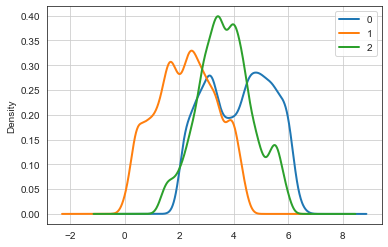

In [ ]:

df_embedding = pd.DataFrame(embedding_umap)
# print(embedding.shape)
# print(df_embedding.describe())
df_embedding.loc[:,:2].plot(kind="density", lw=2, grid=True);

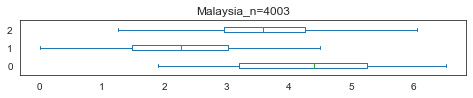

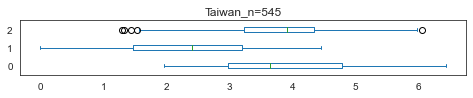

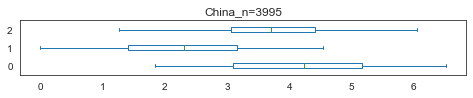

In [ ]:
embedding_list= [df_embedding.loc[idx, :3] for idx in idxs]  #　['Malaysia', 'Taiwan', 'China]
figsize = (8,1)
for embedding_, title in zip(embedding_list,loc_size):
    embedding_.loc[:,:2].plot.box(title=title,figsize=figsize, vert=False);

In [ ]:
#### 建立

---

In [14]:
#### 從群聚層級檢視表徵多樣性


#### 檢視氣候變異與型態多樣性間的關聯- 找出關鍵特徵


##### 檢視在不同海拔/溫度下的表徵多樣性
##### 耐溫能力(耐溫範圍、耐溫上、下界)與型態的關係
##### 建立下游任務: eg: 海拔、耐溫範圍預測
- 檢視對應之下游任務中，模型主要反映的區域
        - 特徵圖(feature map)中，對於類別目標改變而有較大反應的像素位置(即gradcam之概念)
